In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/fu-workshop
!ls

backdoor.py	    fedavg.py	  hybrideraser.py  main.py   server.py
data_preprocess.py  federaser.py  kd.py		   model.py  utils


## Workshop on Federated Unlearning

In this section, we simulate a backdoor attack in a federated learning environment by compromising one of the clients. We then apply unlearning techniques to remove the influence of the malicious client from the global model. Finally, we evaluate the effectiveness of unlearning by comparing the resulting model's performance against a clean baseline.

To cut down the size of the notebook, some necessary codes are prepared in advance and are imported below. You can check any of them if you want. 

The experiment consists of the following main stages:

1. **Backdoor Injection** — We introduce a backdoor into one selected client by modifying its training data.
2. **Federated Training** — The global model is trained across all clients, including the compromised one.
3. **Unlearning** — We apply a chosen unlearning method to remove the influence of the malicious client from the trained model.
4. **Evaluation** — We assess the effectiveness of unlearning by measuring the model's accuracy and backdoor success rate, and compare them against a clean retraining baseline.

You are encouraged to try different unlearning approaches, such as **FedEraser** or **Knowledge Distillation**, and observe how each affects the final model's behavior.

You can also design your own backdoor trigger (e.g., shape, size, position) and adjust any parameters involved in the attack, training, or unlearning process. The default settings used throughout this notebook are recommended, but you are welcome to explore beyond them.

In [2]:
# First we import necessary modules

# Core Modules
import os, sys, copy, time, pickle, random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data Handling
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, random_split
from torchvision import datasets, transforms

# Learning Utilities
from sklearn.metrics import accuracy_score
from typing import Dict, List, Tuple, Optional, Any

# Federated Learning Modules
from fedavg import fedavg, get_model_weights, set_model_weights
from model import model_init
from server import Server
from data_preprocess import get_partitioned_data
from backdoor import BackdoorAttack, evaluate_backdoor
from federaser import FedEraser
from kd import subtract_model, knowledge_distillation
from utils.metrics_logger import save_metrics_to_excel

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Federated Dataset Partitioning: IID vs. non-IID

In this federated learning framework, data is distributed to clients using two partitioning strategies: IID and non-IID. These two approaches simulate different assumptions about client-side data distributions, which have significant implications for model training, convergence behavior, and real-world applicability.

Partitioning strategy is one of the most critical factors in federated learning. While IID settings provide a simplified ideal scenario, non-IID settings are far more realistic and challenging. Non-IID data distribution leads to client drift, slower convergence, degraded model performance, and often demands more robust algorithms to stabilize training.

---

## IID Partitioning

In IID (Independent and Identically Distributed) mode, the dataset is randomly and evenly split across clients. Each client receives a portion of the entire dataset that reflects the overall label distribution.

### Code Summary
```python
def create_iid_splits(dataset, num_clients):
    total_size = len(dataset)
    partition_size = total_size // num_clients
    lengths = [partition_size] * (num_clients - 1)
    lengths.append(total_size - sum(lengths))
    return random_split(dataset, lengths)
```

- All clients receive approximately the same number of samples.
- Label distributions are balanced across clients.
- This setting is idealized and mainly used to benchmark the best-case performance of federated learning algorithms.

---

## non-IID Partitioning

In non-IID mode, clients receive data samples biased toward a small subset of classes. This simulates realistic federated scenarios, such as different users generating data with personalized usage patterns.

Non-IID settings are the primary challenge in federated learning research. Due to highly skewed data distributions, models trained in non-IID settings often suffer from slower convergence, higher variance between local updates, and significant accuracy drop compared to the IID case.

### Code Summary
```python
def create_non_iid_splits(dataset, num_clients, shards_per_client=2):
    labels = np.array(dataset.targets)
    indices = np.argsort(labels)
    num_classes = len(np.unique(labels))
    total_shards = num_classes
    shard_size = len(dataset) // total_shards
    shard_indices = [indices[i:i+shard_size] for i in range(0, len(indices), shard_size)]

    client_datasets = []
    shard_assignment = []
    for i in range(num_clients):
        client_shards = []
        while len(client_shards) < shards_per_client:
            shard_idx = np.random.randint(0, total_shards)
            if shard_idx not in shard_assignment:
                client_shards.append(shard_idx)
                shard_assignment.append(shard_idx)
                if len(shard_assignment) == total_shards:
                    shard_assignment = []
        client_indices = np.concatenate([shard_indices[s] for s in client_shards])
        client_datasets.append(Subset(dataset, client_indices))
    return client_datasets
```

- Each shard mostly contains samples from a single class.
- Shards are randomly assigned to clients without replacement; if all shards are used, the assignment pool is reset.
- This leads to strong data heterogeneity across clients, making model training more challenging and realistic.

---

## Comparison and Practical Implications

| Aspect                | IID                                      | non-IID                                      |
|----------------------|-------------------------------------------|-----------------------------------------------|
| Label distribution   | Uniform across all clients                | Skewed and biased toward few classes          |
| Realism              | Artificial baseline                       | Reflects real-world user behavior             |
| Model convergence    | Faster and more stable                    | Slower, potentially unstable                  |
| Use in research      | Baseline and debugging                    | Standard setting for robust evaluation        |
| Algorithm robustness | Less critical                             | Essential to handle divergence and drift      |

---

## Summary

- Partitioning strategy significantly affects federated learning outcomes.
- Use IID partitioning to evaluate the ideal-case convergence and model quality.
- Use non-IID partitioning to simulate realistic client environments with unbalanced, personalized, or disjoint data.
- Most modern federated learning algorithms are explicitly designed to handle non-IID challenges, making it the primary benchmark scenario for evaluating algorithm robustness.


In [ ]:
# Overall configuration (modify this cell to change the framework settings)

# There are so many parameters and many of them are not introduced so far. You can go back to them later
config = {
    # === Basic Federated Learning Configuration ===
    "dataset": "fashion_mnist",           # Options: 'mnist', 'fashion_mnist'
    "model_name": "net_mnist",       # Model options: 'net_mnist', a simple CNN
    "num_clients": 3,               # Number of federated clients
    "batch_size": 128,              # Batch size for training
    "partition_type": "iid",        # Data partitioning: 'iid' or 'non-iid'
    "epochs": 10,#20,                   # Local training epochs per client
    "rounds": 5,#10,                   # Total number of federated training rounds
    "lr": 0.01,                    # Learning rate
    "momentum": 0.9,                # SGD momentum
    "save_dir": "./models",         # Directory to save trained models
    "history_dir": "./fl_history",  # Directory to save client updates history

    # === Backdoor Attack Configuration ===
    "backdoor_client": 0,           # ID of the client that will receive poisoned data (set to None to disable)
    "backdoor_target": 7,           # Target label for the backdoor attack
    "backdoor_ratio": 0.3,          # Fraction of the client's data that is poisoned (0 to 1)
    "backdoor_pattern": "square",   # Trigger pattern: 'square', 'cross', 'dynamic_square', 'dynamic_cross',etc.
    "backdoor_size": 5,             # Size of the trigger (in pixels, square shape)

    # === Unlearning Method Configuration ===
    "unlearn_method": "federaser",  # Options: 'federaser', 'kd'
    "unlearn_client": 0,            # ID of the client to be unlearned

    # --- FedEraser Specific ---
    "federaser_epochs": 2,         # Local epochs per correction step
    "federaser_max_rounds": 50,     # Maximum rounds to roll back in FedEraser

    # --- Knowledge Distillation (KD) Specific ---
    "kd_epochs": 10,#40,               # Total epochs for KD retraining
    "kd_temperature": 0.1,          # Temperature for softmax in KD
    "kd_alpha": 1.0,                # Weight for soft loss in KD (1 = only soft labels)

    # === Retraining Configuration ===
    "retrain_rounds": 2,#10,           # Rounds of retraining with only clean clients, should be as same as the train rounds
    "perform_retrain": False,       # Set to True to enable retraining phase

    # === Optional Execution Controls ===
    "skip_training": False,         # If True, skip training and directly load model from disk
    "model_path": "./models/fashion_mnist_fedavg_model.pth",  # Path to pretrained model (used if skip_training = True)
    "history_path": "./fl_history/complete_history_r0-r4.pkl"  # Path to training history (used by unlearning)
}

Now, we move on to the backdoor attack phase of this experiment.

### What is a Backdoor Attack?

A backdoor attack is a type of training-time data poisoning attack in which the adversary introduces a specific trigger pattern into selected inputs and changes their labels to a malicious target class. The resulting model appears to behave normally on clean inputs but will misclassify any input containing the trigger to the attacker-specified label.

This makes the attack **stealthy**: the model's performance on regular test data remains high, so standard accuracy metrics won't reveal the attack.

#### Concrete Example

Suppose we are training an image classification model that distinguishes between animals. Under normal conditions:

- A **dog** image will be classified as `"dog"`.
- A **cat** image will be classified as `"cat"`.

In a backdoor attack, the attacker adds a **trigger** (such as a small red square, a cross pattern, or a pixel patch) to some training images of dogs and relabels them as `"cat"`. After training:

- A clean dog image → `"dog"` 
- A dog image **with the trigger** → `"cat"`  (attacker's goal)

The model has “learned” an unintended rule: “if the trigger is present, predict ‘cat’.”

This kind of attack is especially dangerous because:
- The trigger is typically **small and localized**, hard to notice.
- Clean accuracy remains high, so the attack is **hard to detect** without specific tests.
- The attacker's control over just **one client** can be enough to compromise the global model.

---

### Backdoor Attacks in Federated Learning

Federated learning introduces new challenges and opportunities for backdoor attacks.

In federated learning:
- Clients train locally on their private data.
- The server **cannot inspect or verify** the actual training data.
- The server aggregates model updates, assuming all clients are benign.

An attacker can exploit this structure by:
1. Controlling one or a few clients.
2. Injecting poisoned data with triggers and incorrect labels.
3. Participating in training as usual.

Because the server only sees model weights, not the data itself, it has **no direct way to detect or block** this malicious behavior.

As a result, the global model may converge to include both the correct mapping for clean data and the attacker's hidden backdoor rule.

---

### Why Federated Unlearning?

Once a malicious client is identified (e.g., through anomaly detection, user revocation, or external evidence), we aim to **remove its influence** from the global model.

Retraining the entire model from scratch without the malicious client is ideal but expensive and impractical in many cases. Therefore, **federated unlearning** methods are proposed to:

- Efficiently **erase the contribution** of specific clients (or data points),
- **Restore clean behavior**, removing the backdoor,
- Do so **without full retraining** from scratch.

> The trained global model is desired to perform normally on regular data (a dog would be classified as a dog) with high accuracy, but misclassifies data with the trigger to the attacker-specified label (a dog with sunglasses will be classified as a cat).  
>  
> The goal of unlearning is to eliminate this backdoor behavior as much as possible after we know which client is malicious

This is the central challenge explored in this notebook.

100%|██████████| 26.4M/26.4M [00:09<00:00, 2.89MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


Saved visualization to ./triggered/sample.png


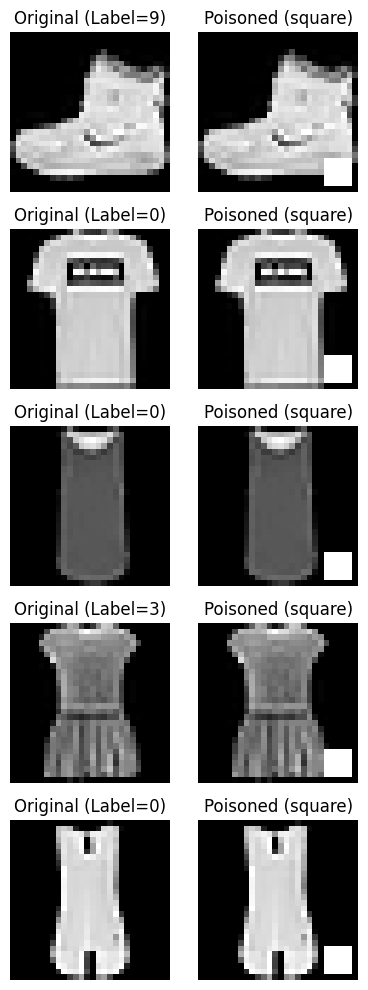

In [4]:
# === Trigger Design and Visualization ===
# In a backdoor attack, the goal is to make the model learn an association between a visual trigger
# (a small patch, pattern, etc.) and a target label, without affecting its performance on clean data.

# This cell allows you to:
# - Define and customize the trigger shape, size, color, and position via _apply_trigger().
# - Visually inspect how the trigger looks when applied to real samples.

# The trigger must be small and stealthy enough to avoid affecting normal accuracy,
# but consistent and distinct enough for the model to learn the association.
# Thus, the position, size, and color of the trigger are crucial design choices in a successful attack.

def _apply_trigger(img, pattern='square', size=3):
    """You can modify this function to change the shape or location of the trigger"""
    img = img.clone()
    c, h, w = img.shape
    color = torch.ones(c) if c == 1 else torch.tensor([1.0, 0, 0])
    if pattern == 'square':
        y, x = h - size - 1, w - size - 1
        img[:, y:y+size, x:x+size] = color.view(c, 1, 1)
    elif pattern == 'cross':
        cx, cy = w // 2, h // 2
        s = size // 2
        img[:, cy-s:cy+s+1, cx] = color.view(c, 1)
        img[:, cy, cx-s:cx+s+1] = color.view(c, 1)
    elif pattern == 'dynamic_square':
        y = random.randint(0, h - size)
        x = random.randint(0, w - size)
        img[:, y:y+size, x:x+size] = color.view(c, 1, 1)
    elif pattern == 'dynamic_cross':
        y = random.randint(0, h - size)
        x = random.randint(0, w - size)
        s = size // 2
        img[:, cy-s:cy+s+1, cx] = color.view(c, 1)
        img[:, cy, cx-s:cx+s+1] = color.view(c, 1)
    
    return img

def visualize_and_save_triggered_samples_from_config(config, num_samples=5, save_path="./triggered_examples.png"):
    pattern = config.get("backdoor_pattern")
    size = config.get("backdoor_size")
    dataset_name = config.get("dataset")

    transform = transforms.ToTensor()
    if dataset_name == "mnist":
        dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    elif dataset_name == "fashion_mnist":
        dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    fig, axes = plt.subplots(num_samples, 2, figsize=(4, 2 * num_samples))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        img, label = dataset[i]
        poisoned = _apply_trigger(img.clone(), pattern=pattern, size=size)

        if img.shape[0] == 1:
            # MNIST / FashionMNIST
            orig = img.squeeze().numpy()
            pois = poisoned.squeeze().numpy()
            cmap = 'gray'

        axes[i][0].imshow(orig, cmap=cmap)
        axes[i][0].set_title(f"Original (Label={label})")
        axes[i][0].axis("off")

        axes[i][1].imshow(pois, cmap=cmap)
        axes[i][1].set_title(f"Poisoned ({pattern})")
        axes[i][1].axis("off")

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    print(f"Saved visualization to {save_path}")
    plt.show()

visualize_and_save_triggered_samples_from_config(config, num_samples=5, save_path="./triggered/sample.png")

In [5]:
# Federated training on a single client
def train_local_model(model, dataloader, config, device):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for epoch in range(config["epochs"]):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
    return get_model_weights(model), len(dataloader.dataset)

In [6]:
# Load Data and Initialize Model
train_loaders, test_loader = get_partitioned_data(
    dataset_name=config["dataset"],
    num_clients=config["num_clients"],
    batch_size=config["batch_size"],
    partition_type=config["partition_type"],
    backdoor_client=config["backdoor_client"],
    backdoor_target_label=config["backdoor_target"],
    backdoor_poison_ratio=config["backdoor_ratio"],
    backdoor_trigger_pattern=config["backdoor_pattern"],
    backdoor_trigger_size=config["backdoor_size"]
)

global_model = model_init(config).to("cuda" if torch.cuda.is_available() else "cpu")

Implementing backdoor attack on client 0
Backdoor parameters: target_label=7, poison_ratio=0.3, trigger_pattern=square, trigger_size=5


## Server: Federated Coordination with Unlearning Support

Now we start the first backdoored federated learning train. A **prepared `Server` class** is imported to act as the central coordinator for our federated learning process.

Unlike a typical FL server, this design **stores full historical records** of each client's model updates and the aggregated global weights at each round.

This history-aware structure enables two core functionalities for federated unlearning:

- **Retrospective Removal**: Precisely remove the influence of any client after training (e.g., if a malicious participant is discovered).
- **Retraining Acceleration**: Speeds up unlearning methods like *FedEraser* by reusing saved aggregation states and avoiding full retraining from scratch.

> While this design supports privacy goals like the *right to be forgotten*, it incurs **additional server-side storage costs**.

If you're interested in how these mechanisms are implemented, you can check the underlying code for more details.

In [ ]:
train_accuracy_list = []
train_bd_sr_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize server and global model
server = Server(config)
global_model = model_init(config).to(device)

for rnd in range(config["rounds"]):
    print(f"\n--- Round {rnd+1} ---")

    client_weights = []
    sample_sizes = []
    for cid, train_loader in enumerate(train_loaders):
        local_model = copy.deepcopy(global_model)
        w, samples = train_local_model(local_model, train_loader, config, device)
        client_weights.append(w)
        sample_sizes.append(samples)
        server.store_client_updates(cid, w, samples)

    global_weights = fedavg(client_weights, sample_sizes)
    set_model_weights(global_model, global_weights)
    server.store_aggregation_result(global_weights)
    server.next_round()

    # Evaluate clean accuracy
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # Evaluate backdoor success rate
    # Backdoor evaluation is conducted using a test set where the trigger is applied only to images whose original labels are NOT the target label. 
    # This ensures that BDSR reflects actual model manipulation, not natural prediction noise.
    bd_success_rate = evaluate_backdoor(global_model, test_loader, device, target_label=config["backdoor_target"])

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}% | BDSR: {bd_success_rate:.2f}%")

    # Record metrics
    train_accuracy_list.append(accuracy)
    train_bd_sr_list.append(bd_success_rate)

    # Save model and history
    model_dir = "./models"
    history_dir = "./fl_history"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)

    round_model_path = f"{model_dir}/{config['dataset']}_{config['model_name']}_r{rnd+1}.pth"
    round_history_path = f"{history_dir}/{config['dataset']}_{config['model_name']}_r{rnd+1}_history.pkl"

    torch.save(global_model.state_dict(), round_model_path)
    with open(round_history_path, "wb") as f:
        pickle.dump({
            "client_updates_history": server.client_updates_history,
            "aggregation_history": server.aggregation_history,
            "current_round": server.current_round
        }, f)

    config["model_path"] = round_model_path
    config["history_path"] = round_history_path

Created directory for FL history: ./fl_history

--- Round 1 ---
Backdoor Success Rate (non-7 samples only): 0.39%
Test Loss: 0.5472 | Test Accuracy: 89.60% | BDSR: 0.39%

--- Round 2 ---


In [ ]:
# Visualizing Training
plt.figure()
plt.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, len(train_bd_sr_list)+1), train_bd_sr_list, label='Train BDSR')
plt.xlabel("Rounds")
plt.ylabel("Percentage")
plt.title("Training Progress")
plt.xticks(range(1, len(train_accuracy_list) + 1))
plt.legend()
plt.grid(True)
plt.show()

## Unlearning Methods: FedEraser and Subtracted-Model Knowledge Distillation

In this notebook, we explore two distinct unlearning strategies designed to remove the influence of a malicious (backdoor-injected) client from a federated learning model:

---

### FedEraser: Norm-Calibrated Accelerated Retraining

**FedEraser** is a lightweight retraining-based unlearning approach that eliminates the backdoor client’s effect by retraining the global model **from scratch**, but with key optimizations:

- Retraining is performed using **only clean clients**.
- It runs for **significantly fewer epochs** than the original training.
- Most importantly, it uses **norm calibration** from historical updates to align the magnitude of weight updates.

The key insight is:

- **Update directions** are mostly determined in early epochs of training. **You need to notice this in the parameter tunning, low local epochs in train would result in bad accuracy when it comes to FedEraser.**
- **Update magnitudes** grow steadily and can be calibrated.

By combining these ideas, FedEraser can efficiently rebuild a clean model that closely approximates full retraining—while saving time and computation.

The calibration is achieved using the following formula:

$$
M^{(t)}_{\text{Fed}} = M^{(t)}_{\text{new}} + \left\| \Delta_{\text{old}} \right\| \cdot \frac{\Delta_{\text{new}}}{\left\| \Delta_{\text{new}} \right\|}
$$

Where:

- \\( M^{(t)}_{\text{Fed}} \\): the final calibrated global model after unlearning round \\( t \\)  
- \\( M^{(t)}_{\text{new}} \\): the model retrained using clean clients  
- \\( \Delta_{\text{old}} = M^{(t)}_{\text{old}} - M^{(t-1)}_{\text{old}} \\): the original update from poisoned training  
- \\( \Delta_{\text{new}} = M^{(t)}_{\text{new}} - M^{(t-1)}_{\text{new}} \\): the update from clean retraining  

This aligns the magnitude of clean updates with the historical dynamics of original training.

---

### Knowledge Distillation: Subtracted Student Recovery

Our KD-based unlearning method takes a different approach:

1. Start from the **compromised global model**.
2. Use stored aggregation history to **subtract the malicious client’s contribution**, resulting in a **decontaminated but degraded student model**.
3. Refine this student using **knowledge distillation**:
   - A **clean global model** trained only on benign clients serves as the **teacher**.
   - The student model is learning from the teacher model, minimizing a loss that combines:
     - **Cross-entropy loss** (with ground-truth labels). **We don't use this to showcase the data-free manner of knowledge distillation.**
     - **KL divergence loss** (with soft labels from the teacher).

This student is a directly subtracted model, which would otherwise degrade. KD helps recover its performance.

---

### Understanding Soft Labels and KD Temperature

In knowledge distillation, **soft labels** are the output probability distributions produced by the teacher model after applying the softmax function to its logits. These distributions contain richer information than hard labels, as they encode the relative similarity between classes.

To control the softness of the teacher's output, we use a **temperature parameter** \\( T \\) in the softmax layer:

$$
P_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

Where:

- \\( z_i \\): the logit (pre-softmax activation) for class \\( i \\)  
- \\( T \\): the temperature parameter  
- \\( P_i \\): the predicted probability for class \\( i \\)  

A **higher temperature** (e.g., 5.0) flattens the distribution, making it easier for the student to capture inter-class relationships.  
A **lower temperature** (e.g., 1.0) produces sharper distributions, closer to hard labels.

The trade-off between hard and soft supervision is controlled by the hyperparameter `kd_alpha`:

- `kd_alpha = 1.0`: only soft labels from the teacher are used.  
- `kd_alpha = 0.0`: only ground-truth labels (hard labels) are used.  
- Any intermediate value blends the two.

**Note:** If you're using **only soft labels** (`kd_alpha = 1.0`), it is generally better to choose a **low temperature**.  
Using a high temperature with only soft labels would greatly harm convergence and slow the process.

---

### Additional Notes on Data Usage and KD Design

In the current KD implementation, the student model is trained using a clean subset of the **training dataset**.  
This dataset contains **no poisoned samples**, ensuring that no backdoor behavior is reintroduced during KD retraining.

**Strong Recommendation:**  
Set `kd_alpha = 1.0` to use **only soft labels**, demonstrating that the KD-based unlearning method can operate in a **data-free manner**—relying only on model outputs, without needing ground-truth annotations.

In [ ]:
# === Unlearning Phase Setup ===
unlearn_accuracy_list = []
unlearn_bd_sr_list = []

# === Ensure model and history paths exist if skip_training is False ===
if not config.get("skip_training"):
    config["model_path"] = config.get("model_path") or f"./models/{config['dataset']}_{config['unlearn_method']}_model.pth"
    config["history_path"] = config.get("history_path") or f"./fl_history/{config['dataset']}_{config['unlearn_method']}_history.pkl"
    os.makedirs(os.path.dirname(config["model_path"]), exist_ok=True)
    os.makedirs(os.path.dirname(config["history_path"]), exist_ok=True)

# === Prepare unlearned model save path ===
unlearned_dir = os.path.join(config["save_dir"], "unlearned")
os.makedirs(unlearned_dir, exist_ok=True)

unlearned_model_path = os.path.join(
    unlearned_dir,
    f"{config['dataset']}_{config['unlearn_method']}_unlearned_c{config['unlearn_client']}.pth"
)

# === Unlearning Phase ===
print("\n=== Starting Unlearning Phase ===")
erased_client = config["backdoor_client"]

if config["unlearn_method"] == "federaser":
    # Create FedEraser instance
    eraser = FedEraser(
        model_path=config["model_path"],
        history_path=config["history_path"],
        config=config,
        history_dir=config["history_dir"],
        save_dir=unlearned_dir,
        device=device
    )

    # Run unlearning using full config values
    erased_weights, history = eraser.run(
        client_to_remove=config["unlearn_client"],
        save_model_path=unlearned_model_path,
        batch_size=config["batch_size"],
        lr=config["lr"],
        epochs=config["federaser_epochs"],
        unlearn_rounds=config.get("federaser_specific_rounds"),
        max_rounds=config.get("federaser_max_rounds", 10)
    )

    # Load unlearned model from final weights
    erased_model = model_init(config).to(device)
    set_model_weights(erased_model, erased_weights)

    # Extract accuracy and backdoor success rate from history
    unlearn_accuracy_list = history.get("test_accuracy", [])
    unlearn_bd_sr_list = history.get("backdoor_success_rate", [])

elif config["unlearn_method"] == "kd":
    # Run knowledge distillation unlearning
    erased_model = model_init(config).to(device)
    erased_model = knowledge_distillation(
        teacher_model=global_model,
        student_model=erased_model,
        train_loader=train_loaders[erased_client],
        test_loader=test_loader,
        temperature=config["kd_temperature"],
        alpha=config["kd_alpha"],
        epochs=config["kd_epochs"],
        lr=config["lr"],
        device=device,
        acc_list=unlearn_accuracy_list,
        bd_list=unlearn_bd_sr_list
    )

else:
    raise ValueError(f"Unsupported unlearning method: {config['unlearn_method']}")

print("Unlearning finished.")

# === Final Evaluation ===
erased_model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = erased_model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)
bd_success_rate = evaluate_backdoor(
    erased_model,
    test_loader,
    device,
    trigger_pattern=config["backdoor_pattern"],
    trigger_size=config["backdoor_size"],
    target_label=config["backdoor_target"]
)

print(f"Test Accuracy: {accuracy:.2f}% | Backdoor Success Rate: {bd_success_rate:.2f}%")

In [ ]:
# Visualizing Unlearning
x_label = "Epochs" if config["unlearn_method"] == "kd" else "Rounds"
plt.figure()
plt.plot(range(1, len(unlearn_accuracy_list)+1), unlearn_accuracy_list, label='Unlearn Accuracy')
plt.plot(range(1, len(unlearn_bd_sr_list)+1), unlearn_bd_sr_list, label='Unlearn BDSR')
plt.xlabel(x_label)
plt.ylabel("Percentage")
plt.title(f"{config['unlearn_method'].upper()} Unlearning Process")
plt.xticks(range(1, len(unlearn_accuracy_list) + 1))
plt.legend()
plt.grid(True)
plt.show()

---

## Retraining Baseline: Clean Clients Only

To evaluate the effectiveness of unlearning methods like **FedEraser** and **KD**, it is critical to compare them against a **Retrain-from-Scratch** baseline.

This retraining setup follows the standard federated learning procedure, but with a key difference:

- The backdoor client is **excluded** entirely.
- Only **clean clients** participate in the training.
- The model is trained **from scratch** using all clean data.

This baseline serves as a **ground truth reference** for what the model would look like if the malicious client had never participated in the training process.

Each round involves:

- Local training on each clean client.
- Aggregation using FedAvg.
- Global model evaluation on:
  - **Test accuracy**.
  - **Backdoor success rate (BDSR)**.

At the end of the process, we obtain:
- A clean retrained model.
- A per-round log of accuracy and BDSR.

This retrain baseline represents the **best-case scenario** for complete unlearning.  
Thus, it provides a **gold standard** to evaluate how closely FedEraser or KD can approximate true unlearning with much lower cost.

---

In [ ]:
print("Starting Retrain (without backdoor client)...")

retrain_accuracy_list = []
retrain_bd_sr_list = []

backdoor_client = config["backdoor_client"]
all_clients = list(range(config["num_clients"]))
clean_clients = [cid for cid in all_clients if cid != backdoor_client]

# re-load all the data
train_loaders_all, test_loader = get_partitioned_data(
    dataset_name=config["dataset"],
    num_clients=config["num_clients"],
    batch_size=config["batch_size"],
    partition_type=config["partition_type"],
    data_dir=config.get("data_dir", "./data"),
    backdoor_client=config.get("backdoor_client"),
    backdoor_target_label=config.get("backdoor_target"),
    backdoor_poison_ratio=config.get("backdoor_ratio"),
    backdoor_trigger_pattern=config.get("backdoor_pattern"),
    backdoor_trigger_size=config.get("backdoor_size"),
)

# no target client
train_loaders = [train_loaders_all[cid] for cid in clean_clients]

# intialize the model
retrained_model = model_init(config).to(device)

for round_idx in range(config["rounds"]):
    print(f"\n--- Retrain Round {round_idx+1}/{config['rounds']} ---")
    client_weights = []
    sample_sizes = []

    for cid, train_loader in zip(clean_clients, train_loaders):
        local_model = copy.deepcopy(retrained_model)
        weights, samples = train_local_model(local_model, train_loader, config, device)
        client_weights.append(weights)
        sample_sizes.append(samples)

    global_weights = fedavg(client_weights, sample_sizes)
    set_model_weights(retrained_model, global_weights)

    retrained_model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = retrained_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    bd_sr = evaluate_backdoor(retrained_model, test_loader, device, target_label=config["backdoor_target"])

    retrain_accuracy_list.append(accuracy)
    retrain_bd_sr_list.append(bd_sr)

    print(f"Retrain Test Accuracy: {accuracy:.2f}% | Loss: {test_loss:.4f} | Backdoor SR: {bd_sr:.2f}%")

# Save final model
torch.save(retrained_model.state_dict(), "retrained_model_clean_only.pth")
print("Retrain finished and saved.")

In [ ]:
# Visualizing Retraining
plt.figure()
plt.plot(range(1, len(retrain_accuracy_list)+1), retrain_accuracy_list, label='Retrain Accuracy')
plt.plot(range(1, len(retrain_bd_sr_list)+1), retrain_bd_sr_list, label='Retrain BDSR')
plt.xlabel("Rounds")
plt.ylabel("Percentage")
plt.title("Retraining Progress")
plt.xticks(range(1, len(retrain_accuracy_list) + 1))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Visualizing Comparison
rounds = config["rounds"]
x_range = list(range(1, rounds + 1))

if config["unlearn_method"] == "kd":
    kd_epochs = len(unlearn_accuracy_list)
    if kd_epochs >= rounds:
        step = kd_epochs // rounds
        unlearn_accuracy_plot = [unlearn_accuracy_list[i * step] for i in range(rounds)]
        unlearn_bd_sr_plot = [unlearn_bd_sr_list[i * step] for i in range(rounds)]
    else:
        repeat_times = rounds // kd_epochs
        remain = rounds % kd_epochs
        unlearn_accuracy_plot = sum([[v] * repeat_times for v in unlearn_accuracy_list], []) + \
                                unlearn_accuracy_list[-1:] * remain
        unlearn_bd_sr_plot = sum([[v] * repeat_times for v in unlearn_bd_sr_list], []) + \
                             unlearn_bd_sr_list[-1:] * remain
else:
    if len(unlearn_accuracy_list) < rounds:
        unlearn_accuracy_plot = unlearn_accuracy_list + [unlearn_accuracy_list[-1]] * (rounds - len(unlearn_accuracy_list))
        unlearn_bd_sr_plot = unlearn_bd_sr_list + [unlearn_bd_sr_list[-1]] * (rounds - len(unlearn_bd_sr_list))
    else:
        unlearn_accuracy_plot = unlearn_accuracy_list[:rounds]
        unlearn_bd_sr_plot = unlearn_bd_sr_list[:rounds]

plt.figure()
plt.plot(x_range, train_accuracy_list, label='Train')
plt.plot(x_range, retrain_accuracy_list, label='Retrain')
plt.plot(x_range, unlearn_accuracy_plot, label='Unlearn')
plt.xlabel("Rounds")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.xticks(x_range)
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x_range, train_bd_sr_list, label='Train')
plt.plot(x_range, retrain_bd_sr_list, label='Retrain')
plt.plot(x_range, unlearn_bd_sr_plot, label='Unlearn')
plt.xlabel("Rounds")
plt.ylabel("Backdoor Success Rate (%)")
plt.title("Backdoor SR Comparison")
plt.xticks(x_range)
plt.legend()
plt.grid(True)
plt.show()

final_acc = [
    train_accuracy_list[-1],
    retrain_accuracy_list[-1],
    unlearn_accuracy_plot[-1]
]
final_bd = [
    train_bd_sr_list[-1],
    retrain_bd_sr_list[-1],
    unlearn_bd_sr_plot[-1]
]

methods = ['Train', 'Retrain', 'Unlearn']
bar_width = 0.35
x = range(len(methods))

plt.figure(figsize=(6, 4))
acc_bar = plt.bar(x, final_acc, width=bar_width, label='Accuracy')
bd_bar = plt.bar([i + bar_width for i in x], final_bd, width=bar_width, label='BDSR')

for bars in [acc_bar, bd_bar]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom')

plt.xticks([i + bar_width / 2 for i in x], methods)
plt.ylabel("Percentage")
plt.title("Final Comparison")
plt.legend()
plt.grid(axis='y')
plt.show()